# Solving the Lindblad dynamics of a qubit ring

In this tutorial we walk through an example of solving the time evolution of the density matrix of coupled qubits using `LindbladMPOSolver`. This tutorial solves the same model solved in the tutorial about Lindblad dynamics within the qiskit_dynamics package (for more information see https://qiskit.org/documentation/dynamics/tutorials/Lindblad_dynamics_simulation.html).

The model that we solve consists of a time-independent Hamiltonian for qubits interacting with their nearest neighbors along a ring. In addition, energy relaxation terms acting on each qubit are modeled by using a Markovian master equation in Lindblad form. We will discuss the system's steady state as a function of the model parameters.

In the sections below we define the model, solve the dynamics and plot some observables using the following steps:

 1. Import the required packages and define the environment.
 2. Define the solver and model parameters.
 3. Solve (evolve the system state from the defined initial state).
 4. Calculate mean expectation values.
 5. Plot some observables and discuss the results.

The model that we solve describes the time evolution of $N$ qubits with coherent dynamics dictated by a given Hamiltonian, and the environment modeled as a memory-less (Markovian) bath. Together, the density matrix evolves according to the Lindblad master equation,

$$\partial_t\rho = -\frac{i}{\hbar} \left[H,\rho\right] + \mathcal{D}[\rho].$$
The Hamiltonian is composed of a sum of single-qubit terms and two-qubit interactions,

$$H = H_0 + H_I.$$
We take the qubits to have identical parameters, with a diagonal term of frequency $\nu_z$ and a transverse term of amplitude $\nu_x$. The single-qubit part of the Hamiltonian is

$$H_0 = \frac{1}{2}\sum_i^N \left[2 \pi \nu_z {Z}_i + 2 \pi \nu_x {X}_i\right],$$
where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices for qubit $i$ (also written as $\sigma_i^a$ with $a\in\{x,y,z\}$).

We set the interactions between nearest-neighbor qubits to be of "flip-flop" type, also called "XY" coupling. We consider periodic boundary conditions, such that the last qubit is connected to the first qubit as well, with

$$H_I =  \frac{1}{2} \sum_{\langle i,j\rangle}2 \pi J \left[{X_i X_j} + {Y_i Y_j}\right]$$
Each qubit's ground state is by convention the state $|0\rangle$ which is the eigenstate of $Z$ with eigenvalue 1 (the state that is known also as "up"). Therefore the action of energy relaxation terms describing damping into the environment tend to bring qubits to this state, as generated by the Lindblad dissipator

$$\mathcal{D}[\rho] = \sum_i \Gamma\left(\sigma_i^+ \rho\sigma_i^- - \frac{1}{2} \{\sigma_i^- \sigma_i^+,\rho\}\right),$$
with $\sigma_i^{\pm}= \frac{1}{2}\left(X_i\pm i Y_i\right)$.

We will calculate single-qubit Pauli expectation values for each qubit as a function of time (which define also the Bloch vector).

$$\langle\sigma_i^a(t)\rangle,$$
Using these observables we will calculate the mean components of the collective Bloch vector over all qubits, at each evaluation time,

$$\frac{1}{N}\sum_i\langle\sigma_i^a(t)\rangle.$$
and we will use these results to calculate and plot the steady state of the system.

## 1. Define the packages environment

In [1]:
import os
import sys
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# add the package path to the PYTHONPATH to enable importing the package
module_path = os.path.abspath(os.path.join('..')) # assuming the notebook is one herirchy below the package
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lindbladmpo.LindbladMPOSolver import *
from lindbladmpo.plot_routines import *

## 2. Define the solver and model parameters

We define all the relevant model parameters in a dictionary format, and pass this dictionary to the solver object. In this tutorial we set by default the problem to be solved for 6 qubits, as in the qiskit_dynamics tutorial mentioned above. The MPO solver is capable of solving such models with relatively large number of qubits, by calculating approximated solutions. One can control the balance between efficient and accurate calculation by varying the numerical parameters of the solver. In the example of solving the problem for only 6 qubits and using the default numerical parameters, we can have both a fast calculation and an exact solution. You are encouraged to run this example with larger numbers of qubits, and explore for which number of qubits and what paraemeters the results start to be an approximation!

For more information about other parameters that the solver accepts, see the API documentation.

In [2]:
##########################
# environment parameters #
##########################

s_output_path = os.path.abspath('./output') + '/'
if not os.path.exists(s_output_path):
    os.mkdir(s_output_path)
s_file_prefix = "chain_tutorial"

####################
# model parameters #
####################

# basic parameters
N = 6
t_init = 0 # this is also the default value
t_final = 2
tau = 0.01
output_files_prefix = s_output_path + s_file_prefix


nu_z = 4
nu_x = 1
XY_interaction = 4
# Hamiltonian coefficients (remember that the Hamiltonian is defined with an overal factor of 1/2)
h_z = 2 * np.pi * nu_z
h_x = 2 * np.pi * nu_x
J = 2 * np.pi * XY_interaction
J_z = 0 # this is also the default value

# Dissipation coefficients
g_0 = 4

# Lattice
# We want to model a ring consisting N qubits
l_x = N
l_y = 1 # this is also the default value
b_periodic_x = True

# Observables
one_qubit_observables = ['x', 'y', 'z']
two_qubits_observables = []

# Create the parameters dictionary
solver_params = {'N': N, 't_init': t_init, 't_final': t_final,  'tau': tau,
                 'output_files_prefix': output_files_prefix,
                 'h_x': h_x, 'h_z': h_z, 'J': J, 'J_z': J_z, 'g_0': g_0,
                 'l_x': l_x, 'l_y': l_y, 'b_periodic_x': b_periodic_x,
                 '1q_components': one_qubit_observables, '2q_components': two_qubits_observables}

## 3. Solve

In [3]:
# Initialize the class
solver = LindbladMPOSolver(solver_params)
# Execute simulator
solver.solve()

## 4. Calculate mean expectation values
Since both the model and the initial state as defined above are translation invariant (all qubits have identical parameters, and there is no boundary), we expect the solution to remain translation invariant as well. Hence the mean Bloch vector should be equal to any qubit's Bloch vector, and observing that this equality holds is a simple and useful verification of the numerical solution that will be added in the next section.

In [4]:
x_expectation_values = np.array([[solver.result['obs-1q'][('x', (i,))][1][t] 
                                for t in range(len(solver.result['obs-1q'][('x', (i,))][0]))] for i in range(N)])
y_expectation_values = np.array([[solver.result['obs-1q'][('y', (i,))][1][t] 
                                for t in range(len(solver.result['obs-1q'][('y', (i,))][0]))] for i in range(N)])
z_expectation_values = np.array([[solver.result['obs-1q'][('z', (i,))][1][t] 
                                for t in range(len(solver.result['obs-1q'][('z', (i,))][0]))] for i in range(N)])

n_steps = x_expectation_values.shape[1]
x_mean = [np.mean(x_expectation_values[:, i]) for i in range(n_steps)]
y_mean = [np.mean(y_expectation_values[:, i]) for i in range(n_steps)]
z_mean = [np.mean(z_expectation_values[:, i]) for i in range(n_steps)]

## 5. Plot some observables and discuss the results
Finally, let's plot some of the results of our dynamical simulation, using the single-qubit observables calculated as a function of time. We plot both the time evolution of the collective Bloch vector, and the Bloch vector at the final time, depicted in 3D within the Bloch sphere. We also print a warning if the Bloch vector at the final time is not translation invariant according to a simplified random check of two values (taken up to a small numerical precision).

Looking at the figures below, we see that for the above parameters the steady state is nearly pure, with a large ground state component and a small tilt along the negative $x$ axis. The direction and magnitude of the collective Bloch vector is determined by a nontrivial competition between the single-site terms, the qubit interactions, and the damping. To test this statement, if you go back and vary the interaction strength $J$, you can see that the steady state may change significantly. For example for $J=1$ the collective Bloch vector will significantly tilt along $+x$, while for $J=3$ it will significantly shorten (the steady state becomes a mixed state), becoming tilted along $-y$. This complex dependence of the Bloch vector on the parameters can be systematically analyzed - we encourage you to try it!

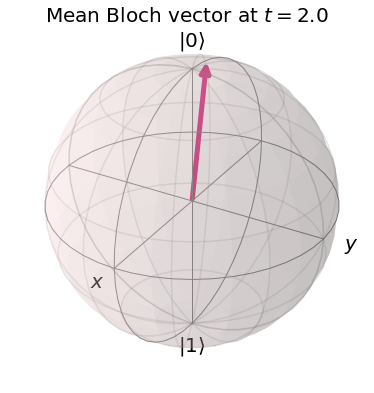

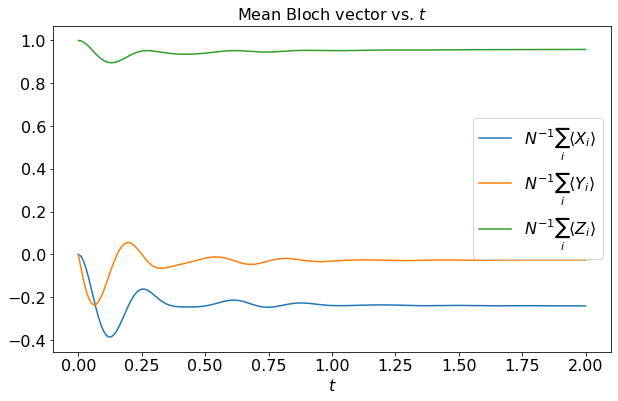

In [5]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt

fontsize = 16

t_eval = np.linspace(t_init, t_final, n_steps)

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, x_mean, label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')
plt.plot(t_eval, y_mean, label = '$ N^{-1}\sum_i \\langle Y_i \\rangle$')
plt.plot(t_eval, z_mean, label = '$ N^{-1}\sum_i \\langle Z_i \\rangle$')
plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title('Mean Bloch vector vs. $t$', fontsize = fontsize)

display(plot_bloch_vector([x_mean[-1], y_mean[-1], z_mean[-1]], f'Mean Bloch vector at $t = {t_eval[-1]}$'))

if N > 1 and ((abs(x_mean[-1]) > 1e-5 and abs(x_expectation_values[0, -1] / x_mean[-1] - 1) > 1e-5 or
              (abs(z_mean[-1]) > 1e-5 and abs(z_expectation_values[1, -1] / z_mean[-1] - 1) > 1e-5))):
    print("The solution at the final time appears to break translation invariance. "
          "The precision of the simulation should be examined.")